In [32]:
%load_ext autoreload
%autoreload 2

import probly

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data and create neural network

In [33]:
transforms = T.Compose([T.ToTensor(), torch.flatten])
train = torchvision.datasets.FashionMNIST(root='~/datasets/', train=True, download=True, transform=transforms)
test = torchvision.datasets.FashionMNIST(root='~/datasets/', train=False, download=True, transform=transforms)
train_loader = DataLoader(train, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

ood = torchvision.datasets.MNIST(root='~/datasets/', train=False, download=True, transform=transforms)
ood_loader = DataLoader(ood, batch_size=256, shuffle=False)

# small fully connected neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### Make neural network a dropout model using probly

In [34]:
model = probly.models.dropout.Dropout(net)

### Train model as usual

In [35]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
for _ in tqdm(range(10)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, 1).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
# compute accuracy on test set
correct = 0
total = 0
model.eval()
for inputs, targets in test_loader:
    outputs = model(inputs, 100).mean(axis=1)
    outputs = outputs.argmax(axis=1)
    correct += (outputs == targets).sum().item()
    total += targets.size(0)
print(f"Accuracy: {correct / total}")

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


Accuracy: 0.8398


### Compute epistemic uncertainty for in-distribution (MNIST) and out-of-distribution (FashionMNIST) data using probly

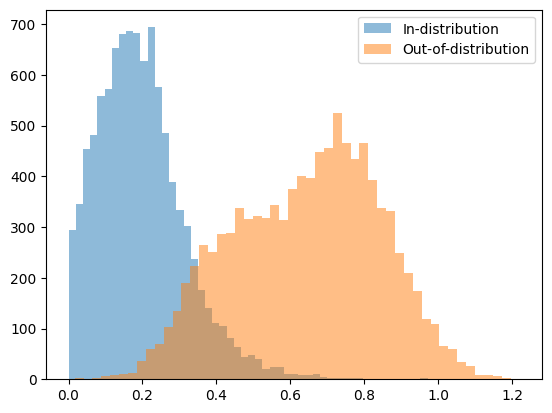

In [36]:
@torch.no_grad()
def torch_get_outputs(model, loader):
    outputs = torch.empty(0)
    targets = torch.empty(0)
    for inputs, targets_ in loader:
        outputs_ = model(inputs, 100)
        outputs = torch.cat((outputs, outputs_), dim=0)
        targets = torch.cat((targets, targets_), dim=0)
    return outputs, targets

# get all outputs
outputs_id, _ = torch_get_outputs(model, test_loader)
outputs_ood, _ = torch_get_outputs(model, ood_loader)
outputs_id = F.softmax(outputs_id, dim=2).numpy()
outputs_ood = F.softmax(outputs_ood, dim=2).numpy()

# compute uncertainties
uncertainty_id = probly.measures.distributions.epistemic_uncertainty_entropy(outputs_id)
uncertainty_ood = probly.measures.distributions.epistemic_uncertainty_entropy(outputs_ood)

# plot them in same histogram
plt.hist(uncertainty_id, bins=50, alpha=0.5, label='In-distribution')
plt.hist(uncertainty_ood, bins=50, alpha=0.5, label='Out-of-distribution')
plt.legend()
plt.show()

### Do Out-of-Distribution task using probly

In [37]:
auroc = probly.tasks.out_of_distribution_detection(uncertainty_id, uncertainty_ood)
print(f'AUROC with FashionMNIST as iD and MNIST as OoD: {auroc:.3f}')

AUROC with FashionMNIST as iD and MNIST as OoD: 0.971
